<h1>Sprint 3</h1>
<b>Sistema de Recomendación</b>

<b>Grupo: </b>
<ul>
    <li><b>Cornelio Edgardo: </b><a>eliseoc1@gmail.com </a></li>
    <li><b>Parra Iván: </b><a>ivanparra01@gmail.com</a></li>
</ul>

<b>Importamos librerías</b>

In [49]:
# Los de siempre
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# datetime
from datetime import datetime

# matrices
from scipy.sparse import csr_matrix

# models
from lightfm import LightFM

# Datos

<b>train.csv</b>

In [50]:
%%time
df_train = pd.read_csv('./train.csv', delimiter=',', parse_dates=['tunein', 'tuneout'])

CPU times: user 3.6 s, sys: 393 ms, total: 3.99 s
Wall time: 5.09 s


In [51]:
df_train.head(1)

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00,2021-02-18 23:35:00,0


<b>metadata.csv</b>

In [52]:
%%time
df_metadatos = pd.read_csv("./metadata.csv", delimiter=";", parse_dates=['create_date', 'modify_date', 'start_vod_date', 'end_vod_date'])

CPU times: user 585 ms, sys: 20.1 ms, total: 605 ms
Wall time: 698 ms


In [53]:
df_metadatos.head(1)

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,...,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
0,15188,0.0,Ep:17 Tiempos Compulsivos,Tiempos_Compul_E17,Episodio 17,Serie,2012.0,AR,Drama,"Trastornos,Médicos,Tragicómica,Telenovela,Enfe...",...,N,N,N,N,N,N,2017-12-01 10:18:15+00:00,2019-01-26 06:37:18+00:00,2017-12-01 00:00:00+00:00,2020-12-01 23:59:59+00:00


<b>Merge entre ambos datasets</b>

In [54]:
%%time
df = df_train.merge(df_metadatos, how="left", left_on="asset_id", right_on="asset_id")

CPU times: user 3.5 s, sys: 392 ms, total: 3.89 s
Wall time: 3.88 s


In [55]:
df = df[[
        # df_train
        'account_id', 'tunein', 'tuneout', 
        # df_metadatos
        'content_id', 'title', 'end_vod_date'
        ]]

In [56]:
df.head(1)

,account_id,tunein,tuneout,content_id,title,end_vod_date
0,90627,2021-02-18 22:52:00,2021-02-18 23:35:00,2040.0,T:5 Ep:08 This is Us,2021-06-30 23:59:59+00:00


# Train - Test Split

<b>Train</b>

In [57]:
train = df[df.tunein <= datetime(year=2021, month=3, day=1)]

In [58]:
train.shape

(2339070, 6)

<b>Test</b>

In [59]:
test = df[df.tunein > datetime(year=2021, month=3, day=1)]

In [60]:
test.shape

(1318731, 6)

# Contenido no disponible

Se filtran todos aquellos contenidos que no van a estar disponibles después de la fecha de train (01-03-2021)

In [61]:
df['end_vod_date'] = pd.to_datetime(df['end_vod_date'], format='%Y/%m/%d')
df["end_vod_date"] = pd.to_datetime(df["end_vod_date"]).dt.date

In [62]:
not_available_content_df = df[['content_id', 'end_vod_date']].groupby('content_id', as_index=False).agg({'end_vod_date': 'max'})
not_available_content = not_available_content_df[not_available_content_df['end_vod_date'] < datetime(year=2021, month=3, day=1).date()]['content_id'].values

# Interacciones

Armamos un dataset con las interacciones account - content.

In [63]:
interactions = train[['account_id', 'content_id']].copy()
interactions.head()

,account_id,content_id
0,90627,2040.0
6,3388,2100.0
7,3388,2100.0
8,3388,2100.0
9,3388,2100.0


<b>Elimino los nulos</b>

In [64]:
print(f"Antes: {interactions.shape}")
interactions = interactions.dropna()
print(f"Ahora: {interactions.shape}")

Antes: (2339070, 2)
Ahora: (2339046, 2)


<b>Elimino los duplicados</b>

In [65]:
print(f"Antes: {interactions.shape}")
interactions = interactions.drop_duplicates()
print(f"Ahora: {interactions.shape}")

Antes: (2339046, 2)
Ahora: (672124, 2)


<b>Cuentas únicas</b>

In [66]:
interactions.account_id.nunique()

99647

<b>Contenidos únicos</b>

In [67]:
interactions.content_id.nunique()

3692

# Rating

El enfoque más simple es considerar que si la cuenta vió el contenido entonces le gusto, por lo tanto tendrá un 1 como rating.

In [68]:
interactions['rating'] = 1

In [69]:
interactions.head()

,account_id,content_id,rating
0,90627,2040.0,1
6,3388,2100.0,1
12,3388,691.0,1
30,3388,3487.0,1
38,3388,3038.0,1


# Matriz de Interacción

Construimos la matriz de interacción. Los valores de esta matriz van a ser 1 si el usuario vio el contenido y 0 si no lo vió.

In [70]:
interactions_matrix = pd.pivot_table(interactions, index='account_id', columns='content_id', values='rating')

In [71]:
interactions_matrix.shape 

(99647, 3692)

In [72]:
interactions_matrix.head()

content_id,0.0,1.0,3.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,...,4357.0,4358.0,4359.0,4360.0,4361.0,4362.0,4363.0,4364.0,4365.0,4366.0
account_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b>Completamos los NaN con ceros</b>

In [73]:
interactions_matrix = interactions_matrix.fillna(0)

In [74]:
interactions_matrix.head()

content_id,0.0,1.0,3.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,...,4357.0,4358.0,4359.0,4360.0,4361.0,4362.0,4363.0,4364.0,4365.0,4366.0
account_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Armamos diccionario de accounts que vamos a usar más adelante al momento de armar las predicciones

In [75]:
user_id = list(interactions_matrix.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

Transformamos la matriz a csr matrix (compressed sparse row)

In [76]:
interactions_matrix_csr = csr_matrix(interactions_matrix.values)

# Modelo

Creamos nuestra función de recomendación utilizando la librería LFM (light fm) para crear el modelo.

In [77]:
model = LightFM(loss='warp',
                random_state=100,
                learning_rate=0.03,
                no_components=100)

Entrenamos el modelo con 10 epochs

In [78]:
%%time
model = model.fit(interactions_matrix_csr, epochs=10)

CPU times: user 15.8 s, sys: 0 ns, total: 15.8 s
Wall time: 15.8 s


# Cold start

Popularidad de contenido para cold start: agrupamos por contenidos más vistos.

In [79]:
popularity_df = train.groupby("content_id", as_index=False).agg({"account_id":"nunique"})\
    .sort_values(by="account_id", ascending=False) 

most_popular = popularity_df['content_id'][0:50].values
most_popular = [x for x in most_popular if x not in not_available_content]

popularity_df.head(50).content_id.values

array([2040., 3806., 3900., 3598., 2160., 3381., 1462., 3690., 3210.,
       3550., 3384., 2627., 3711., 1316., 3775., 3382.,  116., 3716.,
       2827., 3712.,  724., 2942., 1020., 2815., 1971.,  580., 1008.,
       1139., 3863., 3726., 2972., 3035., 3578.,  558., 2992.,  173.,
        135., 1877., 3026., 2012., 2323., 3572.,  171.,  729., 3292.,
       1140.,  292., 2817., 3502., 1665.])

# Generación de recomendaciones

In [80]:
%%time
# definimos dict donde vamos a ir almacenando las recomendaciones
recomms_dict = {
    'user_id': [],
    'recomms': [],
    'cold': []
}

#obtenemos cantidad de usuarios y cantidad de items
n_users, n_items = interactions_matrix.shape
item_ids = np.arange(n_items)

#por cada usuario del dataset completo, generamos recomendaciones
for user in tqdm(test.account_id.unique()): 

    # if user in list(interactions_matrix_1.index):
    if user in interactions_matrix.index:

        # Si el usuario esta en train, no es cold start. Usamos el modelo para recomendar
        user_x = user_dict[user] #buscamos el indice del usuario en la matriz (transformamos id a indice)


        preds = model.predict(user_ids=user_x, item_ids = item_ids)


        scores = pd.Series(preds)
        scores.index = interactions_matrix.columns
        scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]


        # Obtenemos listado de contenidos vistos anteriormente por el usuario (en el set de train)
        watched_contents = train[train.account_id == user].content_id.unique()

        # Filtramos contenidos ya vistos y quedarse con los primeros 10
        recomms = [x for x in scores if x not in watched_contents]
        recomms = [x for x in recomms if x not in not_available_content]

        # Guardamos las recomendaciones en el diccionario
        recomms_dict['user_id'].append(user)
        recomms_dict['recomms'].append(recomms[0:20])
        recomms_dict['cold'].append(False)

    # En este else trataremos a los usuarios que no están en la matriz (cold start)
    else:
        recomms_dict['user_id'].append(user)
        # Les recomendamos contenido popular
        recomms_dict['recomms'].append(popularity_df.content_id.to_list()[:20])
        recomms_dict['cold'].append(True)

100%|██████████| 87635/87635 [05:24<00:00, 269.69it/s] 

CPU times: user 5min 25s, sys: 1.68 s, total: 5min 27s
Wall time: 5min 24s


Convertimos a dataframe el diccionario de recomendaciones

In [81]:
recomms = pd.DataFrame(recomms_dict)
recomms = recomms.sort_values(by='user_id', ascending=True)

In [82]:
recomms.head()

,user_id,recomms,cold
74072,2,"[2040.0, 3026.0, 1020.0, 3025.0, 3295.0, 1800....",False
74107,3,"[3210.0, 3035.0, 2815.0, 3711.0, 3519.0, 2972....",False
74198,4,"[2827.0, 3806.0, 1720.0, 2815.0, 3900.0, 2040....",False
74212,5,"[3806.0, 3382.0, 3900.0, 2160.0, 3775.0, 3598....",False
74398,6,"[3716.0, 116.0, 2040.0, 1140.0, 3900.0, 1462.0...",False


# Visualizaciones reales de los usuarios

Ahora tenemos que comparar nuestras recomendaciones contra lo que los usuarios realmente vieron (test).

Primero ordenamos las visualizaciones por perfil y armamos un listado de los content_id vistos.

Este es el listado "ideal" contra el que vamos a comparar nuestras recomendaciones.

In [83]:
%%time
ideal_recomms = test[['account_id', 'content_id']]\
                .drop_duplicates()\
                .groupby(by='account_id', as_index=False)\
                .agg({'content_id': 'unique'})\
                .sort_values(by='account_id')

CPU times: user 6.47 s, sys: 19.9 ms, total: 6.49 s
Wall time: 6.5 s


In [84]:
ideal_recomms.head()

,account_id,content_id
0,2,[433.0]
1,3,"[1949.0, 2409.0, 4010.0, 3169.0, 3487.0, 3980...."
2,4,"[2314.0, 728.0, 4129.0, 2344.0, 2341.0, 513.0,..."
3,5,[2259.0]
4,6,"[3902.0, 3211.0, 2900.0, 3386.0, 4065.0, 3388.0]"


# Evaluacion: Métrica MAP

Utilizaremos la métrica MAP (Mean Average Precision) para observar la performance del modelo

In [85]:
preds = recomms.recomms.values
labels = ideal_recomms.content_id.values

In [86]:
aps = [] # lista vacía para ir almacenando la AP de cada recomendación
for pred, label in zip(preds, labels):
    n = len(pred) 
    arange = np.arange(n, dtype=np.int32) + 1. # indexamos en base 1
    rel_k = np.in1d(pred[:n], label)
    tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # lista con el contador de verdaderos positivos
    denom = arange[rel_k] # posiciones donde se encuentran los ítems relantes
    ap = (tp / denom).sum() / len(label) # average precision
    aps.append(ap)

In [87]:
print(f"MAP = { {round(np.mean(aps), 5)}}")

MAP = {0.02852}


# Modificando hiperparámetros del modelo para obtener mejores métricas

In [90]:
def recomm_lightfm(model, interactions_matrix, interactions_matrix_csr, not_available_content, most_popular):
    
    # definimos dict donde vamos a ir almacenando las recomendaciones
    recomms_dict = {
        'user_id': [],
        'recomms': [],
        'cold': []
    }

    #obtenemos cantidad de usuarios y cantidad de items
    n_users, n_items = interactions_matrix.shape
    item_ids = np.arange(n_items)

    #por cada usuario del dataset completo, generamos recomendaciones
    for user in tqdm(test.account_id.unique()): 

        # if user in list(interactions_matrix_1.index):
        if user in interactions_matrix.index:

            # Si el usuario esta en train, no es cold start. Usamos el modelo para recomendar
            user_x = user_dict[user] #buscamos el indice del usuario en la matriz (transformamos id a indice)

           
            preds = model.predict(user_ids=user_x, item_ids = item_ids)

            
            scores = pd.Series(preds)
            scores.index = interactions_matrix.columns
            # scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]
            scores = pd.Series(scores.sort_values(ascending=False).index)[:50]

            # Obtenemos listado de contenidos vistos anteriormente por el usuario (en el set de train)
            watched_contents = train[train.account_id == user].content_id.unique()

            # Filtramos contenidos ya vistos y quedarse con los primeros 10
            recomms = [x for x in scores if x not in watched_contents]
            recomms = [x for x in recomms if x not in not_available_content]

            # Guardamos las recomendaciones en el diccionario
            recomms_dict['user_id'].append(user)
            recomms_dict['recomms'].append(recomms[0:20])
            recomms_dict['cold'].append(False)

        # En este else trataremos a los usuarios que no están en la matriz (cold start)
        else:
            recomms_dict['user_id'].append(user)
            # Les recomendamos contenido popular
            # recomms_dict['recomms'].append(popularity_df.content_id.to_list())
            recomms_dict['recomms'].append(most_popular)
            recomms_dict['cold'].append(True)
    return recomms_dict

def calcular_MAP(ideal_recomms, recomms):
    preds = recomms.recomms.values
    labels = ideal_recomms.content_id.values
    
    aps = [] # lista vacía para ir almacenando la AP de cada recomendación
    for pred, label in zip(preds, labels):
        n = len(pred) 
        arange = np.arange(n, dtype=np.int32) + 1. # indexamos en base 1
        rel_k = np.in1d(pred[:n], label)
        tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # lista con el contador de verdaderos positivos
        denom = arange[rel_k] # posiciones donde se encuentran los ítems relantes
        ap = (tp / denom).sum() / len(label) # average precision
        aps.append(ap)
    
    return round(np.mean(aps), 5)

In [91]:
# Definimos hiperparametros del modelo
random_state = 0
learning_rate = 0.03
components = [x for x in range(10, 201, 10)]
epochs = 10

MAP_dict = {}

for component in components:

    model = LightFM(loss='warp', random_state=random_state, learning_rate=learning_rate, no_components=component)
                       
    model = model.fit(interactions_matrix_csr, epochs=epochs)

    recomendations_dic = recomm_lightfm(model, interactions_matrix, interactions_matrix_csr, not_available_content, most_popular)

    recomendations_df = pd.DataFrame(recomendations_dic)
    
    MAP = calcular_MAP(ideal_recomms, recomendations_df)
    
    MAP_dict[component] = MAP

df_MAP = pd.DataFrame(MAP_dict.items(), columns=['Componente', 'MAP'])

100%|██████████| 87635/87635 [04:25<00:00, 330.57it/s] 


In [94]:
df_MAP[0:10]

,Componente,MAP
0,10,0.03714
1,20,0.03404
2,30,0.03220
3,40,0.03112
4,50,0.03132
5,60,0.02962
6,70,0.02983
7,80,0.02965
8,90,0.02904
9,100,0.02938


<Figure size 432x288 with 0 Axes>

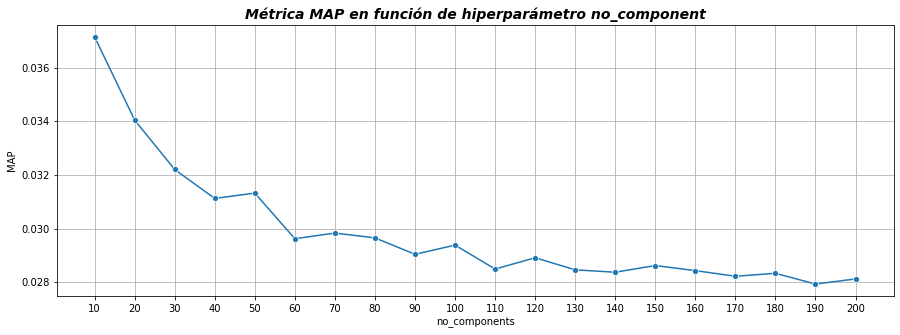

In [93]:
plt.clf()
plt.figure(figsize=(15,5))
sns.lineplot(data=df_MAP, x='Componente', y='MAP', marker="o")
plt.title('Métrica MAP en función de hiperparámetro no_component', fontdict={'fontsize': 14,'fontweight':'bold', 'style':'italic'})
#plt.xticks([x for x in range(df_MAP['Componente'].min(), df_MAP['Componente'].max() +1,1)], rotation=90)
plt.xticks([x for x in range(10, 201, 10)])
plt.xlabel('no_components')
plt.grid(0.6)
plt.show()